In [64]:
import os
import sys
import numpy as np
import pandas as pd
import torch


import matplotlib.pyplot as plt
from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility, characters
from pommerman.constants import Action
from torch.nn.parameter import Parameter
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

Actions: 
    Stop = 0,
    Up = 1,
    Down = 2,
    Left = 3,
    Right = 4,
    Bomb = 5

In [6]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [7]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

In [8]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

In [48]:
#n_inputs = env.observation_space.shape[0]
n_inputs = 121
#n_hidden = 20
n_hidden = 11
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)



state shape: 121
action shape: 6


In [79]:
# training settings
debug = False
num_episodes = 10

discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 1 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        
        # Add four random agents
        agents = []
        #for agent_id in range(4):
        #    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
        agents = {
            '0' : SimpleAgent(config["agent"](0, config["game_type"])),
            '1' : RandomAgent(config["agent"](1, config["game_type"])),
            '2' : RandomAgent(config["agent"](2, config["game_type"])),
            '3' : FirstAgent(config["agent"](3, config["game_type"]))
        }
        env.set_agents(list(agents.values()))
        env.set_init_game_state(None)
        
        s = env.reset()
        done = False
        while(not done):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s[3]['board'].flatten())).float())
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            
            
            actions = env.act(obs)
            actions[3] = a
            
            obs, reward, done, info = env.step(actions)
            
            #Introduced flatten on the board
            rollout.append((s[3]['board'].flatten(), a, reward[3]))
            
            s = obs
            if done: break
                
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        
        # policy gradient update
        policy.optimizer.zero_grad()
        #print ( torch.from_numpy(actions) )
        if i < 2 and debug:
            print("torch.from_numpy(states).float()")
            print(torch.from_numpy(states).float())
            print(torch.from_numpy(states).float())
            print()
            
            print("policy(torch.from_numpy(states).float())")
            print(policy(torch.from_numpy(states).float()))
            print(policy(torch.from_numpy(states).float()).size())
            print()
            
            print("torch.from_numpy(actions))")
            print(torch.from_numpy(actions))
            print(torch.from_numpy(actions).size())
            print()
            
            print("policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions))")
            print(policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)))
            print()
            
            print("policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)")
            print(policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1))
            print()
        
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s[3]['board'].flatten())).float()).argmax().item()
                        
                    actions = env.act(obs)
                    actions[3] = a
                    s, r, done, info = env.step(actions)
                    reward += r[3]
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
   1. mean training reward: -13.00, mean validation reward: -19.50, mean loss: -15.7462
   2. mean training reward: -37.00, mean validation reward:  -7.20, mean loss: -47.5126
   3. mean training reward:  -1.00, mean validation reward: -14.40, mean loss: -1.8413
   4. mean training reward: -13.00, mean validation reward:  -8.20, mean loss: -17.7734
   5. mean training reward:  -2.00, mean validation reward:  -9.60, mean loss: -3.3336
   6. mean training reward:  -6.00, mean validation reward:  -0.50, mean loss: -9.3306
   7. mean training reward: -22.00, mean validation reward: -11.10, mean loss: -29.9873
   8. mean training reward: -15.00, mean validation reward:  -6.10, mean loss: -19.1143
   9. mean training reward:  -6.00, mean validation reward:  -8.80, mean loss: -8.6926
  10. mean training reward:  -5.00, mean validation reward:  -5.50, mean loss: -7.8871
done


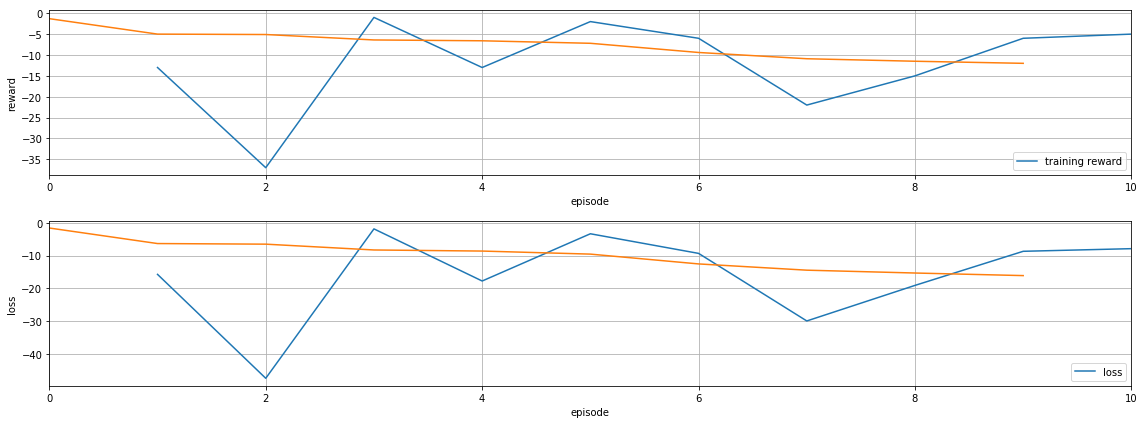

In [80]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

In [3]:
class FirstAgent(BaseAgent):
    
    def __init__(self, character=characters.Bomber):
        super().__init__(character)

    def act(self, obs, action_space):
        # Kald neuralt netværk og return
        return Action['Stop']

In [68]:
# Add four random agents
agents = []
#for agent_id in range(4):
#    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
agents = {
    '0' : SimpleAgent(config["agent"](0, config["game_type"])),
    '1' : RandomAgent(config["agent"](1, config["game_type"])),
    '2' : RandomAgent(config["agent"](2, config["game_type"])),
    '3' : FirstAgent(config["agent"](3, config["game_type"]))
}
env.set_agents(list(agents.values()))
env.set_init_game_state(None)

In [69]:
# Seed and reset the environment
env.seed(0)
obs = env.reset()

# Run the random agents until we're done
done = False
while not done:
    env.render()
    actions = env.act(obs)
    obs, reward, done, info = env.step(actions)
env.render(close=True)
env.close()

print(info)
print (done)

{'result': <Result.Win: 0>, 'winners': [0]}
True


In [34]:
print (dir(env))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agent_view_size', '_agents', '_board', '_board_size', '_bombs', '_env', '_flames', '_game_type', '_get_done', '_get_info', '_get_rewards', '_init_game_state', '_intended_actions', '_is_partially_observable', '_items', '_max_steps', '_mode', '_num_items', '_num_rigid', '_num_wood', '_powerups', '_render_fps', '_set_action_space', '_set_observation_space', '_step_count', '_viewer', 'act', 'action_space', 'close', 'featurize', 'get_json_info', 'get_observations', 'make_board', 'make_items', 'metadata', 'model', 'np_random', 'observation_space', 'observations', 'render', 'reset', 'reward_range', 'save_json', 'seed', 'set_agents', 'set_init_game_stat

In [116]:
s = env.reset()
#print(s)

#a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
#print (torch.from_numpy(np.atleast_2d(s)))
test = np.asarray(s)
print (s[0]['board'])
print (torch.from_numpy(s[0]['board']))

[[ 0  0  2  1  2  2  1  1  2  0  2]
 [ 0 10  0  0  2  2  2  0  0 13  1]
 [ 2  0  0  0  0  0  1  1  0  0  0]
 [ 1  0  0  0  1  2  2  1  2  0  0]
 [ 2  2  0  1  0  2  2  1  1  2  0]
 [ 2  2  0  2  2  0  1  2  1  2  2]
 [ 1  2  1  2  2  1  0  1  0  2  1]
 [ 1  0  1  1  1  2  1  0  1  0  1]
 [ 2  0  0  2  1  1  0  1  0  0  1]
 [ 0 11  0  0  2  2  2  0  0 12  1]
 [ 2  1  0  0  0  2  1  1  1  1  0]]
tensor([[ 0,  0,  2,  1,  2,  2,  1,  1,  2,  0,  2],
        [ 0, 10,  0,  0,  2,  2,  2,  0,  0, 13,  1],
        [ 2,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0],
        [ 1,  0,  0,  0,  1,  2,  2,  1,  2,  0,  0],
        [ 2,  2,  0,  1,  0,  2,  2,  1,  1,  2,  0],
        [ 2,  2,  0,  2,  2,  0,  1,  2,  1,  2,  2],
        [ 1,  2,  1,  2,  2,  1,  0,  1,  0,  2,  1],
        [ 1,  0,  1,  1,  1,  2,  1,  0,  1,  0,  1],
        [ 2,  0,  0,  2,  1,  1,  0,  1,  0,  0,  1],
        [ 0, 11,  0,  0,  2,  2,  2,  0,  0, 12,  1],
        [ 2,  1,  0,  0,  0,  2,  1,  1,  1,  1,  0]], dtype=to

In [178]:
# creating DataFrame from targets_data
#targets_df = pd.DataFrame(data=targets_data)
#targets_df.columns = ['targets']

# creating tensor from targets_df 
#torch_tensor = torch.tensor(targets_df['targets'].values)

# printing out result
#print(torch_tensor
dataFrame = pd.DataFrame(data=s)
columns = dataFrame.columns 
torchTenssor = dataFrame[columns].values

#print(dataFrame.values.ravel('C'))
print(dataFrame.stack())
#print (torch.tensor(.columns.values))

0  alive                                                               [13]
   ammo                                                                   1
   blast_strength                                                         2
   board                  [[0, 2, 1, 0, 1, 1, 0, 2, 1, 0, 1], [2, 0, 0, ...
   bomb_blast_strength    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
   bomb_life              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
   can_kick                                                           False
   enemies                          [Item.Agent1, Item.Agent2, Item.Agent3]
   game_env                                         pommerman.envs.v0:Pomme
   game_type                                                              1
   position                                                          (1, 1)
   step_count                                                            15
   teammate                                                 Item.AgentDummy
1  alive    